In [1]:
%cd ../../../../

/home/users/dmoreno2016/ASTROMER/astromer_pe/astromer/presentation/experiments/astromer_1_pe


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import glob
import toml
import os

In [3]:
pretraining_path = 'results/pretraining/P02R01/macho_pe_nontrainable-2023-09-18_01-12-37'
finetuning_path = 'results/finetuning/P02R01/macho_pe_nontrainable'

datasets_names = ['alcock', 'atlas', 'ogle']
subsets = [500]
folds = [0, 1, 2]

In [6]:
datasets_names = ['alcock', 'atlas', 'ogle', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']
subsets = [50]

In [7]:
## Pretraining metrics
dict_logs_pretraining = dict()

for subset_name in subsets:
    with open(os.path.join(pretraining_path, 'test_metrics_datasets_{}.toml'.format(subset_name)), 'r') as f:
        dict_logs_pretraining['{}'.format(subset_name)] = toml.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results/pretraining/P02R01/macho_pe_nontrainable-2023-09-18_01-12-37/test_metrics_datasets_50.toml'

In [20]:
dict_pt_metrics = {
    'mean': {
        'r2': {k: [] for k in datasets_names},
        'rmse': {k: [] for k in datasets_names},
        'time_epoch': {k: 0 for k in datasets_names},
        'time_batch': {k: 0 for k in datasets_names},
    },

    'std': {
        'r2': {k: [] for k in datasets_names},
        'rmse': {k: [] for k in datasets_names},
        'time_epoch': {k: 0 for k in datasets_names},
        'time_batch': {k: 0 for k in datasets_names},
    },
}

In [21]:
for subset in subsets:
    for ds_name in datasets_names:            
        list_r2, list_rmse, list_time_epoch, list_time_batch = [], [], [], []
        for fold in folds:
            list_r2.append(dict_logs_pretraining['{}'.format(subset)][ds_name]['fold_{}'.format(fold)]['r_square'])
            list_rmse.append(dict_logs_pretraining['{}'.format(subset)][ds_name]['fold_{}'.format(fold)]['rmse'])
            
        dict_pt_metrics['mean']['r2'][ds_name].append(np.mean(list_r2))
        dict_pt_metrics['mean']['rmse'][ds_name].append(np.mean(list_rmse))

        dict_pt_metrics['std']['r2'][ds_name].append(np.std(list_r2))
        dict_pt_metrics['std']['rmse'][ds_name].append(np.std(list_rmse))

    for stat_name, dict_metric in dict_pt_metrics.items():

        for metric_name, dict_results in dict_metric.items():
            dict_pt_metrics['{}'.format(stat_name)]['{}'.format(metric_name)] = pd.DataFrame(dict_results, 
                                                                                             index=['Without FT'])

In [22]:
dict_pt_metrics

{'mean': {'r2':               alcock       atlas      ogle
  Without FT  0.808045 -187.191127  0.705856,
  'rmse':               alcock      atlas      ogle
  Without FT  0.011068  13.129022  0.014463,
  'time_epoch':             alcock  atlas  ogle
  Without FT       0      0     0,
  'time_batch':             alcock  atlas  ogle
  Without FT       0      0     0},
 'std': {'r2':               alcock      atlas      ogle
  Without FT  0.003293  19.343192  0.032853,
  'rmse':               alcock     atlas      ogle
  Without FT  0.001276  0.845125  0.001831,
  'time_epoch':             alcock  atlas  ogle
  Without FT       0      0     0,
  'time_batch':             alcock  atlas  ogle
  Without FT       0      0     0}}

## Extract finetuning metrics

In [8]:
## Finetuning metrics

dict_logs_finetuning = dict()
for path_lr_files in glob.glob('{}/*'.format(finetuning_path)):
    lr = path_lr_files.split('/')[-1]

    dict_logs_finetuning[lr] = dict()
    for path_science_cases in glob.glob('{}/*'.format(path_lr_files)):
        spc = path_science_cases.split('/')[-1]

        dict_logs_finetuning[lr][spc] = dict()
        for path_ds_name in glob.glob('{}/*'.format(path_science_cases)):
            ds_name = path_ds_name.split('/')[-1]

            #if ds_name in ds_names:

            dict_logs_finetuning[lr][spc][ds_name] = dict()
            for path_fold in glob.glob('{}/*'.format(path_ds_name)):
                fold_name = path_fold.split('/')[-1]

                dict_logs_finetuning[lr][spc][ds_name][fold_name] = dict()
                for path_subsets in glob.glob('{}/*'.format(path_fold)):
                    subset_name = path_subsets.split('/')[-1]

                    #if subset_name.split('_')[-1] in subsets:
                    
                    with open(os.path.join(path_subsets, 'metrics.toml'), 'r') as f:
                        metrics = toml.load(f)

                    dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name] = dict()
                    #for files in ['metrics', 'time_epoch', 'time_batch']:
                    dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['metrics'] = metrics
                    dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['time_batch'] = pd.read_csv(os.path.join(path_subsets, 'time_batch.csv'))
                    dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['time_epoch'] = pd.read_csv(os.path.join(path_subsets, 'time_epoch.csv'))


In [9]:
lr = 'lr_1e-05'

In [10]:
dict_ft_metrics = {
    'mean': {
        'r2': {k: [] for k in datasets_names},
        'rmse': {k: [] for k in datasets_names},
        'time_epoch': {k: [] for k in datasets_names},
        'time_batch': {k: [] for k in datasets_names},
    },

    'std': {
        'r2': {k: [] for k in datasets_names},
        'rmse': {k: [] for k in datasets_names},
        'time_epoch': {k: [] for k in datasets_names},
        'time_batch': {k: [] for k in datasets_names},
    },
}

for subset in subsets:

    list_idx = []
    for idx_name in list(dict_logs_finetuning['lr_1e-05'].keys()):

        for ds_name in datasets_names:            

            list_r2, list_rmse, list_time_epoch, list_time_batch = [], [], [], []
            for fold in folds:
                list_r2.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['metrics']['test_r_square'])
                list_rmse.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['metrics']['test_rmse'])
                list_time_epoch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['time_epoch'].time_epoch.values.sum())
                list_time_batch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['time_batch'].time_batch.values.sum())

            dict_ft_metrics['mean']['r2'][ds_name].append(np.mean(list_r2))
            dict_ft_metrics['mean']['rmse'][ds_name].append(np.mean(list_rmse))
            dict_ft_metrics['mean']['time_epoch'][ds_name].append(np.mean(list_time_epoch))
            dict_ft_metrics['mean']['time_batch'][ds_name].append(np.mean(list_time_batch))

            dict_ft_metrics['std']['r2'][ds_name].append(np.std(list_r2))
            dict_ft_metrics['std']['rmse'][ds_name].append(np.std(list_rmse))
            dict_ft_metrics['std']['time_epoch'][ds_name].append(np.std(list_time_epoch))
            dict_ft_metrics['std']['time_batch'][ds_name].append(np.std(list_time_batch))

        list_idx.append(idx_name)
        
    for stat_name, dict_metric in dict_ft_metrics.items():

        for metric_name, dict_results in dict_metric.items():
            dict_ft_metrics['{}'.format(stat_name)]['{}'.format(metric_name)] = pd.DataFrame(dict_results, 
                                                                                          index=list_idx)
            

In [11]:
dict_ft_metrics

{'mean': {'r2':                 kepler_alcock_linear  kepler_atlas_linear  kepler_ogle_linear
  PE                          0.336241            -1.203398           -0.119518
  FF1_PE_ATT_FF2              0.632970             0.133196            0.229473
  FF1_ATT_FF2                 0.640682             0.393916            0.629365
  FF1_PE                      0.283433            -1.493562            0.321263,
  'rmse':                 kepler_alcock_linear  kepler_atlas_linear  kepler_ogle_linear
  PE                          0.003089             0.011111            0.005909
  FF1_PE_ATT_FF2              0.001397             0.004151            0.009726
  FF1_ATT_FF2                 0.001681             0.002891            0.002482
  FF1_PE                      0.003697             0.015073            0.002883,
  'time_epoch':                 kepler_alcock_linear  kepler_atlas_linear  kepler_ogle_linear
  PE                         34.000270            38.300452           37.452427
  

## RMSE v/s Finetuning time

In [29]:
import seaborn as sns

In [62]:
dict_ft_metrics['mean']['r2'].index

Index(['PE', 'FF1_PE_ATT_FF2', 'FF1_ATT_FF2', 'FF1_PE'], dtype='object')

In [63]:
set_layers_trainable = dict_ft_metrics['mean']['r2'].index
set_layers_trainable

Index(['PE', 'FF1_PE_ATT_FF2', 'FF1_ATT_FF2', 'FF1_PE'], dtype='object')

In [74]:
dict_results = {
    'Time Mean': [],
    u'Δ R^2 Mean': [],
    u'Δ RMSE Mean': [],
    'Time Std': [],
    u'Δ R^2 Std': [],
    u'Δ RMSE Std': [],
    'Dataset name': [],
    'Trainable layers': [],
}

for dataset_name in datasets_names:

    for layers_trainable in set_layers_trainable:        

        dict_results['Time Mean'].append(dict_ft_metrics['mean']['time_epoch'][dataset_name].filter(items=[layers_trainable], axis=0).iloc[0])
        dict_results[u'Δ R^2 Mean'].append(dict_ft_metrics['mean']['r2'][dataset_name].filter(items=[layers_trainable], axis=0).iloc[0] \
                                            - dict_pt_metrics['mean']['r2'][dataset_name].filter(items=['Without FT'], axis=0).iloc[0])
        dict_results[u'Δ RMSE Mean'].append(dict_pt_metrics['mean']['rmse'][dataset_name].filter(items=['Without FT'], axis=0).iloc[0] \
                                            - dict_ft_metrics['mean']['rmse'][dataset_name].filter(items=[layers_trainable], axis=0).iloc[0])

        dict_results['Time Std'].append(dict_ft_metrics['std']['time_epoch'][dataset_name].filter(items=[layers_trainable], axis=0).iloc[0])
        dict_results[u'Δ R^2 Std'].append(dict_ft_metrics['std']['r2'][dataset_name].filter(items=[layers_trainable], axis=0).iloc[0])
        dict_results[u'Δ RMSE Std'].append(dict_ft_metrics['std']['rmse'][dataset_name].filter(items=[layers_trainable], axis=0).iloc[0])

        dict_results['Dataset name'].append(dataset_name.upper())
        dict_results['Trainable layers'].append(layers_trainable)

df_results = pd.DataFrame(dict_results)
df_results

,Time Mean,Δ R^2 Mean,Δ RMSE Mean,Time Std,Δ R^2 Std,Δ RMSE Std,Dataset name,Trainable layers
0,91.066089,-0.001906,-0.000573,15.077792,0.004831,0.001698,ALCOCK,PE
1,256.629807,0.001123,0.000276,50.374743,0.003685,0.000873,ALCOCK,FF1_PE_ATT_FF2
2,174.979159,0.006132,0.000700,68.466115,0.000856,0.000906,ALCOCK,FF1_ATT_FF2
3,81.779074,-0.001386,0.000028,13.378001,0.001935,0.000783,ALCOCK,FF1_PE
4,92.881064,171.463123,10.955333,15.348460,0.545137,0.053865,ATLAS,PE
5,252.167423,187.622368,13.051266,92.743748,0.173372,0.024117,ATLAS,FF1_PE_ATT_FF2
6,456.048152,187.509350,13.037978,209.851745,0.436456,0.049796,ATLAS,FF1_ATT_FF2
7,87.371504,172.108181,11.107611,16.064611,0.878112,0.106665,ATLAS,FF1_PE
8,349.037878,-0.002915,0.000979,43.793981,0.049844,0.001599,OGLE,PE
9,1092.578019,0.130629,0.008232,366.608726,0.004473,0.000225,OGLE,FF1_PE_ATT_FF2


In [75]:
df_results_filtered = df_results[df_results['Dataset name'] != 'ATLAS']
df_results_filtered

,Time Mean,Δ R^2 Mean,Δ RMSE Mean,Time Std,Δ R^2 Std,Δ RMSE Std,Dataset name,Trainable layers
0,91.066089,-0.001906,-0.000573,15.077792,0.004831,0.001698,ALCOCK,PE
1,256.629807,0.001123,0.000276,50.374743,0.003685,0.000873,ALCOCK,FF1_PE_ATT_FF2
2,174.979159,0.006132,0.000700,68.466115,0.000856,0.000906,ALCOCK,FF1_ATT_FF2
3,81.779074,-0.001386,0.000028,13.378001,0.001935,0.000783,ALCOCK,FF1_PE
8,349.037878,-0.002915,0.000979,43.793981,0.049844,0.001599,OGLE,PE
9,1092.578019,0.130629,0.008232,366.608726,0.004473,0.000225,OGLE,FF1_PE_ATT_FF2
10,981.372653,0.127116,0.007790,112.541414,0.005090,0.000266,OGLE,FF1_ATT_FF2
11,432.006693,0.042958,0.002641,121.378258,0.047326,0.001348,OGLE,FF1_PE


/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

Text(0.5, 29.000000000000014, 'Training time')

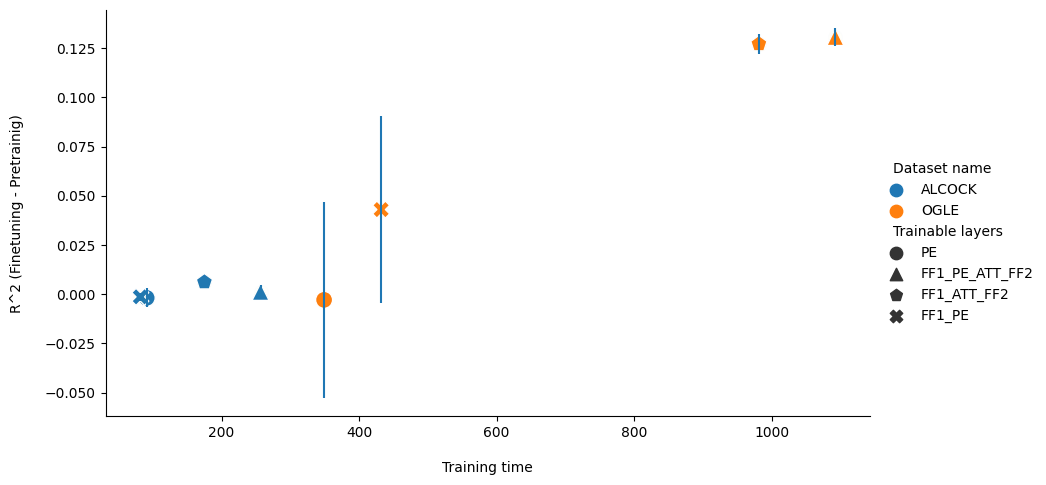

In [76]:
markers_set=['o', '^', 'p', 'X']


ax = sns.relplot(data=df_results_filtered, x='Time Mean', y=u'Δ R^2 Mean', hue='Dataset name', style='Trainable layers', s=150, height=4.8, aspect=1.8,
                 markers=markers_set)

markers, caps, bars = ax.ax.errorbar(df_results_filtered['Time Mean'], df_results_filtered[u'Δ R^2 Mean'],
                                     yerr=df_results_filtered[u'Δ R^2 Std'],
                                     #xerr=df_results['Time Std'],
                                     fmt='o',
                                     markersize=10,
                                     zorder=1, )

markers.set_markerfacecolor((1, 1, 0, 0.01))

for lh in ax._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [80] 

plt.ylabel('R^2 (Finetuning - Pretrainig)', labelpad=15)
plt.xlabel('Training time', labelpad=15)